In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../../_data/Tavares2017.csv')
data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 2 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['Right Value - Left Value'] = data_df['item_value_1'] - data_df['item_value_0']

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])


min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(data_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(data_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(30464, 4) (30464, 4)


In [5]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [6]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [7]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 87        
                                                                 
Total params: 380 (1.48 KB)
Trainable params: 380 (1.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 589ms/step - loss: 163674.8125
Epoch 2/5000
1/1 [==============================] - 0s 8ms/step - loss: 162942.0000
Epoch 3/5000
1/1 [==============================] - 0s 7ms/step - loss: 162409.1406
Epoch 4/5000
1/1 [==============================] - 0s 6ms/step - loss: 161962.1875
Epoch 5/5000
1/1 [==============================] - 0s 6ms/step - loss: 161565.4531
Epoch 6/5000
1/1 [==============================] - 0s 6ms/step - loss: 161202.4062
Epoch 7/5000
1/1 [==============================] - 0s 7ms/step - loss: 160863.8750
Epoch 8/5000
1/1 [==============================] - 0s 6ms/step - loss: 160544.1406
Epoch 9/5000
1/1 [==============================] - 0s 7ms/step - loss: 160239.3281
Epoch 10/5000
1/1 [==============================] - 0s 5ms/step - loss: 159946.6719
Epoch 11/5000
1/1 [==============================] - 0s 6ms/step - loss: 159664.1562
Epoch 12/5000
1/1 [==============================] - 0s 7ms/step - loss:

1/1 [==============================] - 0s 7ms/step - loss: 143461.4062
Epoch 98/5000
1/1 [==============================] - 0s 9ms/step - loss: 143313.1562
Epoch 99/5000
1/1 [==============================] - 0s 8ms/step - loss: 143165.6562
Epoch 100/5000
1/1 [==============================] - 0s 8ms/step - loss: 143018.8906
Epoch 101/5000
1/1 [==============================] - 0s 8ms/step - loss: 142872.8906
Epoch 102/5000
1/1 [==============================] - 0s 8ms/step - loss: 142727.5938
Epoch 103/5000
1/1 [==============================] - 0s 9ms/step - loss: 142583.0781
Epoch 104/5000
1/1 [==============================] - 0s 9ms/step - loss: 142439.2969
Epoch 105/5000
1/1 [==============================] - 0s 8ms/step - loss: 142296.2500
Epoch 106/5000
1/1 [==============================] - 0s 8ms/step - loss: 142153.9375
Epoch 107/5000
1/1 [==============================] - 0s 9ms/step - loss: 142012.3750
Epoch 108/5000
1/1 [==============================] - 0s 9ms/step - los

1/1 [==============================] - 0s 9ms/step - loss: 132217.4844
Epoch 193/5000
1/1 [==============================] - 0s 11ms/step - loss: 132123.6719
Epoch 194/5000
1/1 [==============================] - 0s 10ms/step - loss: 132030.2500
Epoch 195/5000
1/1 [==============================] - 0s 10ms/step - loss: 131937.2031
Epoch 196/5000
1/1 [==============================] - 0s 10ms/step - loss: 131844.5312
Epoch 197/5000
1/1 [==============================] - 0s 9ms/step - loss: 131752.2344
Epoch 198/5000
1/1 [==============================] - 0s 9ms/step - loss: 131660.2812
Epoch 199/5000
1/1 [==============================] - 0s 29ms/step - loss: 131568.7031
Epoch 200/5000
1/1 [==============================] - 0s 11ms/step - loss: 131477.4844
Epoch 201/5000
1/1 [==============================] - 0s 9ms/step - loss: 131386.6250
Epoch 202/5000
1/1 [==============================] - 0s 10ms/step - loss: 131296.1250
Epoch 203/5000
1/1 [==============================] - 0s 9ms/s

1/1 [==============================] - 0s 9ms/step - loss: 123830.2578
Epoch 288/5000
1/1 [==============================] - 0s 9ms/step - loss: 123739.1875
Epoch 289/5000
1/1 [==============================] - 0s 8ms/step - loss: 123648.1406
Epoch 290/5000
1/1 [==============================] - 0s 8ms/step - loss: 123557.1719
Epoch 291/5000
1/1 [==============================] - 0s 8ms/step - loss: 123466.2344
Epoch 292/5000
1/1 [==============================] - 0s 9ms/step - loss: 123375.3594
Epoch 293/5000
1/1 [==============================] - 0s 8ms/step - loss: 123284.5234
Epoch 294/5000
1/1 [==============================] - 0s 8ms/step - loss: 123193.7578
Epoch 295/5000
1/1 [==============================] - 0s 8ms/step - loss: 123103.0000
Epoch 296/5000
1/1 [==============================] - 0s 8ms/step - loss: 123012.3359
Epoch 297/5000
1/1 [==============================] - 0s 8ms/step - loss: 122921.6797
Epoch 298/5000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 114623.1562
Epoch 383/5000
1/1 [==============================] - 0s 8ms/step - loss: 114528.4531
Epoch 384/5000
1/1 [==============================] - 0s 8ms/step - loss: 114434.1172
Epoch 385/5000
1/1 [==============================] - 0s 8ms/step - loss: 114340.0391
Epoch 386/5000
1/1 [==============================] - 0s 8ms/step - loss: 114246.3281
Epoch 387/5000
1/1 [==============================] - 0s 8ms/step - loss: 114152.8594
Epoch 388/5000
1/1 [==============================] - 0s 8ms/step - loss: 114059.7656
Epoch 389/5000
1/1 [==============================] - 0s 9ms/step - loss: 113966.8984
Epoch 390/5000
1/1 [==============================] - 0s 8ms/step - loss: 113874.4062
Epoch 391/5000
1/1 [==============================] - 0s 8ms/step - loss: 113782.1484
Epoch 392/5000
1/1 [==============================] - 0s 8ms/step - loss: 113690.2578
Epoch 393/5000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 106631.3594
Epoch 478/5000
1/1 [==============================] - 0s 8ms/step - loss: 106553.9375
Epoch 479/5000
1/1 [==============================] - 0s 10ms/step - loss: 106476.5156
Epoch 480/5000
1/1 [==============================] - 0s 8ms/step - loss: 106399.3984
Epoch 481/5000
1/1 [==============================] - 0s 8ms/step - loss: 106322.2578
Epoch 482/5000
1/1 [==============================] - 0s 8ms/step - loss: 106245.4375
Epoch 483/5000
1/1 [==============================] - 0s 9ms/step - loss: 106168.5938
Epoch 484/5000
1/1 [==============================] - 0s 8ms/step - loss: 106092.0781
Epoch 485/5000
1/1 [==============================] - 0s 8ms/step - loss: 106015.5312
Epoch 486/5000
1/1 [==============================] - 0s 8ms/step - loss: 105939.3281
Epoch 487/5000
1/1 [==============================] - 0s 8ms/step - loss: 105863.0859
Epoch 488/5000
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 100014.9219
Epoch 573/5000
1/1 [==============================] - 0s 9ms/step - loss: 99952.7031
Epoch 574/5000
1/1 [==============================] - 0s 8ms/step - loss: 99891.0625
Epoch 575/5000
1/1 [==============================] - 0s 9ms/step - loss: 99829.1094
Epoch 576/5000
1/1 [==============================] - 0s 9ms/step - loss: 99767.7266
Epoch 577/5000
1/1 [==============================] - 0s 8ms/step - loss: 99706.0312
Epoch 578/5000
1/1 [==============================] - 0s 8ms/step - loss: 99644.9141
Epoch 579/5000
1/1 [==============================] - 0s 9ms/step - loss: 99583.4688
Epoch 580/5000
1/1 [==============================] - 0s 9ms/step - loss: 99522.6172
Epoch 581/5000
1/1 [==============================] - 0s 8ms/step - loss: 99461.4141
Epoch 582/5000
1/1 [==============================] - 0s 8ms/step - loss: 99400.8047
Epoch 583/5000
1/1 [==============================] - 0s 8ms/step - loss: 99339

1/1 [==============================] - 0s 8ms/step - loss: 94600.1953
Epoch 669/5000
1/1 [==============================] - 0s 9ms/step - loss: 94548.6328
Epoch 670/5000
1/1 [==============================] - 0s 8ms/step - loss: 94497.7031
Epoch 671/5000
1/1 [==============================] - 0s 9ms/step - loss: 94446.3203
Epoch 672/5000
1/1 [==============================] - 0s 8ms/step - loss: 94395.5859
Epoch 673/5000
1/1 [==============================] - 0s 9ms/step - loss: 94344.3828
Epoch 674/5000
1/1 [==============================] - 0s 8ms/step - loss: 94293.8281
Epoch 675/5000
1/1 [==============================] - 0s 8ms/step - loss: 94242.8125
Epoch 676/5000
1/1 [==============================] - 0s 8ms/step - loss: 94192.4453
Epoch 677/5000
1/1 [==============================] - 0s 8ms/step - loss: 94141.6172
Epoch 678/5000
1/1 [==============================] - 0s 7ms/step - loss: 94091.4219
Epoch 679/5000
1/1 [==============================] - 0s 8ms/step - loss: 94040.

1/1 [==============================] - 0s 9ms/step - loss: 90072.7422
Epoch 765/5000
1/1 [==============================] - 0s 8ms/step - loss: 90029.3359
Epoch 766/5000
1/1 [==============================] - 0s 12ms/step - loss: 89986.6172
Epoch 767/5000
1/1 [==============================] - 0s 10ms/step - loss: 89943.3594
Epoch 768/5000
1/1 [==============================] - 0s 8ms/step - loss: 89900.7969
Epoch 769/5000
1/1 [==============================] - 0s 9ms/step - loss: 89857.7109
Epoch 770/5000
1/1 [==============================] - 0s 8ms/step - loss: 89815.3047
Epoch 771/5000
1/1 [==============================] - 0s 9ms/step - loss: 89772.3828
Epoch 772/5000
1/1 [==============================] - 0s 8ms/step - loss: 89730.1406
Epoch 773/5000
1/1 [==============================] - 0s 8ms/step - loss: 89687.3828
Epoch 774/5000
1/1 [==============================] - 0s 8ms/step - loss: 89645.3125
Epoch 775/5000
1/1 [==============================] - 0s 8ms/step - loss: 8960

1/1 [==============================] - 0s 8ms/step - loss: 86297.7969
Epoch 861/5000
1/1 [==============================] - 0s 9ms/step - loss: 86262.1172
Epoch 862/5000
1/1 [==============================] - 0s 8ms/step - loss: 86226.8672
Epoch 863/5000
1/1 [==============================] - 0s 9ms/step - loss: 86191.3281
Epoch 864/5000
1/1 [==============================] - 0s 8ms/step - loss: 86156.1875
Epoch 865/5000
1/1 [==============================] - 0s 8ms/step - loss: 86120.7812
Epoch 866/5000
1/1 [==============================] - 0s 9ms/step - loss: 86085.8203
Epoch 867/5000
1/1 [==============================] - 0s 8ms/step - loss: 86050.5469
Epoch 868/5000
1/1 [==============================] - 0s 9ms/step - loss: 86015.7578
Epoch 869/5000
1/1 [==============================] - 0s 8ms/step - loss: 85980.5938
Epoch 870/5000
1/1 [==============================] - 0s 8ms/step - loss: 85945.9531
Epoch 871/5000
1/1 [==============================] - 0s 8ms/step - loss: 85910.

1/1 [==============================] - 0s 8ms/step - loss: 83223.3125
Epoch 957/5000
1/1 [==============================] - 0s 9ms/step - loss: 83194.6875
Epoch 958/5000
1/1 [==============================] - 0s 8ms/step - loss: 83166.3281
Epoch 959/5000
1/1 [==============================] - 0s 9ms/step - loss: 83137.8281
Epoch 960/5000
1/1 [==============================] - 0s 8ms/step - loss: 83109.6172
Epoch 961/5000
1/1 [==============================] - 0s 8ms/step - loss: 83081.2578
Epoch 962/5000
1/1 [==============================] - 0s 8ms/step - loss: 83053.1562
Epoch 963/5000
1/1 [==============================] - 0s 9ms/step - loss: 83024.9531
Epoch 964/5000
1/1 [==============================] - 0s 9ms/step - loss: 82996.9922
Epoch 965/5000
1/1 [==============================] - 0s 8ms/step - loss: 82968.9141
Epoch 966/5000
1/1 [==============================] - 0s 9ms/step - loss: 82941.0859
Epoch 967/5000
1/1 [==============================] - 0s 9ms/step - loss: 82913.

1/1 [==============================] - 0s 9ms/step - loss: 80790.4922
Epoch 1052/5000
1/1 [==============================] - 0s 9ms/step - loss: 80767.4297
Epoch 1053/5000
1/1 [==============================] - 0s 9ms/step - loss: 80744.4375
Epoch 1054/5000
1/1 [==============================] - 0s 8ms/step - loss: 80721.4219
Epoch 1055/5000
1/1 [==============================] - 0s 9ms/step - loss: 80698.5078
Epoch 1056/5000
1/1 [==============================] - 0s 8ms/step - loss: 80675.6172
Epoch 1057/5000
1/1 [==============================] - 0s 9ms/step - loss: 80652.7734
Epoch 1058/5000
1/1 [==============================] - 0s 8ms/step - loss: 80629.9375
Epoch 1059/5000
1/1 [==============================] - 0s 9ms/step - loss: 80607.2031
Epoch 1060/5000
1/1 [==============================] - 0s 8ms/step - loss: 80584.4609
Epoch 1061/5000
1/1 [==============================] - 0s 9ms/step - loss: 80561.7891
Epoch 1062/5000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 78801.4375
Epoch 1147/5000
1/1 [==============================] - 0s 8ms/step - loss: 78783.0312
Epoch 1148/5000
1/1 [==============================] - 0s 9ms/step - loss: 78764.7500
Epoch 1149/5000
1/1 [==============================] - 0s 8ms/step - loss: 78746.4453
Epoch 1150/5000
1/1 [==============================] - 0s 9ms/step - loss: 78728.2734
Epoch 1151/5000
1/1 [==============================] - 0s 8ms/step - loss: 78710.0703
Epoch 1152/5000
1/1 [==============================] - 0s 9ms/step - loss: 78692.0625
Epoch 1153/5000
1/1 [==============================] - 0s 8ms/step - loss: 78673.9375
Epoch 1154/5000
1/1 [==============================] - 0s 8ms/step - loss: 78656.0469
Epoch 1155/5000
1/1 [==============================] - 0s 8ms/step - loss: 78638.0938
Epoch 1156/5000
1/1 [==============================] - 0s 9ms/step - loss: 78620.3125
Epoch 1157/5000
1/1 [==============================] - 0s 9ms/step - l

Epoch 1241/5000
1/1 [==============================] - 0s 10ms/step - loss: 77323.2969
Epoch 1242/5000
1/1 [==============================] - 0s 10ms/step - loss: 77310.7266
Epoch 1243/5000
1/1 [==============================] - 0s 10ms/step - loss: 77297.7500
Epoch 1244/5000
1/1 [==============================] - 0s 10ms/step - loss: 77285.2266
Epoch 1245/5000
1/1 [==============================] - 0s 10ms/step - loss: 77272.4219
Epoch 1246/5000
1/1 [==============================] - 0s 10ms/step - loss: 77259.9062
Epoch 1247/5000
1/1 [==============================] - 0s 9ms/step - loss: 77247.1875
Epoch 1248/5000
1/1 [==============================] - 0s 9ms/step - loss: 77234.8906
Epoch 1249/5000
1/1 [==============================] - 0s 8ms/step - loss: 77222.0703
Epoch 1250/5000
1/1 [==============================] - 0s 10ms/step - loss: 77209.8750
Epoch 1251/5000
1/1 [==============================] - 0s 9ms/step - loss: 77197.3438
Epoch 1252/5000
1/1 [==========================

1/1 [==============================] - 0s 10ms/step - loss: 76323.4844
Epoch 1336/5000
1/1 [==============================] - 0s 10ms/step - loss: 76315.3125
Epoch 1337/5000
1/1 [==============================] - 0s 10ms/step - loss: 76306.4219
Epoch 1338/5000
1/1 [==============================] - 0s 9ms/step - loss: 76298.3438
Epoch 1339/5000
1/1 [==============================] - 0s 10ms/step - loss: 76289.7344
Epoch 1340/5000
1/1 [==============================] - 0s 10ms/step - loss: 76281.5938
Epoch 1341/5000
1/1 [==============================] - 0s 10ms/step - loss: 76273.1797
Epoch 1342/5000
1/1 [==============================] - 0s 10ms/step - loss: 76265.1719
Epoch 1343/5000
1/1 [==============================] - 0s 9ms/step - loss: 76256.5625
Epoch 1344/5000
1/1 [==============================] - 0s 9ms/step - loss: 76248.7109
Epoch 1345/5000
1/1 [==============================] - 0s 10ms/step - loss: 76240.1094
Epoch 1346/5000
1/1 [==============================] - 0s 9ms/

1/1 [==============================] - 0s 8ms/step - loss: 75662.9062
Epoch 1431/5000
1/1 [==============================] - 0s 9ms/step - loss: 75657.6719
Epoch 1432/5000
1/1 [==============================] - 0s 9ms/step - loss: 75652.2266
Epoch 1433/5000
1/1 [==============================] - 0s 9ms/step - loss: 75645.9531
Epoch 1434/5000
1/1 [==============================] - 0s 9ms/step - loss: 75640.6406
Epoch 1435/5000
1/1 [==============================] - 0s 9ms/step - loss: 75633.5312
Epoch 1436/5000
1/1 [==============================] - 0s 9ms/step - loss: 75628.0078
Epoch 1437/5000
1/1 [==============================] - 0s 8ms/step - loss: 75621.8828
Epoch 1438/5000
1/1 [==============================] - 0s 9ms/step - loss: 75616.9375
Epoch 1439/5000
1/1 [==============================] - 0s 8ms/step - loss: 75611.5156
Epoch 1440/5000
1/1 [==============================] - 0s 8ms/step - loss: 75606.7812
Epoch 1441/5000
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 75214.8281
Epoch 1526/5000
1/1 [==============================] - 0s 8ms/step - loss: 75214.1875
Epoch 1527/5000
1/1 [==============================] - 0s 9ms/step - loss: 75199.2891
Epoch 1528/5000
1/1 [==============================] - 0s 8ms/step - loss: 75193.4922
Epoch 1529/5000
1/1 [==============================] - 0s 9ms/step - loss: 75195.3594
Epoch 1530/5000
1/1 [==============================] - 0s 7ms/step - loss: 75198.1484
Epoch 1531/5000
1/1 [==============================] - 0s 9ms/step - loss: 75192.9375
Epoch 1532/5000
1/1 [==============================] - 0s 8ms/step - loss: 75190.5938
Epoch 1533/5000
1/1 [==============================] - 0s 9ms/step - loss: 75194.1172
Epoch 1534/5000
1/1 [==============================] - 0s 9ms/step - loss: 75194.9219
Epoch 1535/5000
1/1 [==============================] - 0s 9ms/step - loss: 75185.8281
Epoch 1536/5000
1/1 [==============================] - 0s 9ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 74897.4844
Epoch 1621/5000
1/1 [==============================] - 0s 9ms/step - loss: 74899.1875
Epoch 1622/5000
1/1 [==============================] - 0s 10ms/step - loss: 74891.5781
Epoch 1623/5000
1/1 [==============================] - 0s 9ms/step - loss: 74890.8047
Epoch 1624/5000
1/1 [==============================] - 0s 9ms/step - loss: 74933.5547
Epoch 1625/5000
1/1 [==============================] - 0s 10ms/step - loss: 74889.1406
Epoch 1626/5000
1/1 [==============================] - 0s 9ms/step - loss: 74928.7266
Epoch 1627/5000
1/1 [==============================] - 0s 11ms/step - loss: 74882.1406
Epoch 1628/5000
1/1 [==============================] - 0s 11ms/step - loss: 74878.0703
Epoch 1629/5000
1/1 [==============================] - 0s 11ms/step - loss: 74881.3047
Epoch 1630/5000
1/1 [==============================] - 0s 11ms/step - loss: 74872.9375
Epoch 1631/5000
1/1 [==============================] - 0s 12ms/s

1/1 [==============================] - 0s 10ms/step - loss: 74664.8281
Epoch 1715/5000
1/1 [==============================] - 0s 10ms/step - loss: 74663.5312
Epoch 1716/5000
1/1 [==============================] - 0s 11ms/step - loss: 74715.8047
Epoch 1717/5000
1/1 [==============================] - 0s 10ms/step - loss: 74690.5625
Epoch 1718/5000
1/1 [==============================] - 0s 9ms/step - loss: 74688.9844
Epoch 1719/5000
1/1 [==============================] - 0s 9ms/step - loss: 74690.1250
Epoch 1720/5000
1/1 [==============================] - 0s 9ms/step - loss: 74729.0781
Epoch 1721/5000
1/1 [==============================] - 0s 9ms/step - loss: 74677.9688
Epoch 1722/5000
1/1 [==============================] - 0s 10ms/step - loss: 74663.9688
Epoch 1723/5000
1/1 [==============================] - 0s 8ms/step - loss: 74661.8047
Epoch 1724/5000
1/1 [==============================] - 0s 10ms/step - loss: 74649.1484
Epoch 1725/5000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 9ms/step - loss: 74491.7812
Epoch 1810/5000
1/1 [==============================] - 0s 10ms/step - loss: 74491.2500
Epoch 1811/5000
1/1 [==============================] - 0s 9ms/step - loss: 74488.7734
Epoch 1812/5000
1/1 [==============================] - 0s 9ms/step - loss: 74487.0859
Epoch 1813/5000
1/1 [==============================] - 0s 9ms/step - loss: 74484.2734
Epoch 1814/5000
1/1 [==============================] - 0s 9ms/step - loss: 74481.0000
Epoch 1815/5000
1/1 [==============================] - 0s 10ms/step - loss: 74485.1250
Epoch 1816/5000
1/1 [==============================] - 0s 8ms/step - loss: 74480.8125
Epoch 1817/5000
1/1 [==============================] - 0s 9ms/step - loss: 74481.8281
Epoch 1818/5000
1/1 [==============================] - 0s 8ms/step - loss: 74476.9375
Epoch 1819/5000
1/1 [==============================] - 0s 10ms/step - loss: 74476.4375
Epoch 1820/5000
1/1 [==============================] - 0s 9ms/step 

1/1 [==============================] - 0s 9ms/step - loss: 74334.0078
Epoch 1905/5000
1/1 [==============================] - 0s 9ms/step - loss: 74337.9609
Epoch 1906/5000
1/1 [==============================] - 0s 9ms/step - loss: 74336.0938
Epoch 1907/5000
1/1 [==============================] - 0s 10ms/step - loss: 74335.9688
Epoch 1908/5000
1/1 [==============================] - 0s 10ms/step - loss: 74332.0625
Epoch 1909/5000
1/1 [==============================] - 0s 11ms/step - loss: 74334.0859
Epoch 1910/5000
1/1 [==============================] - 0s 12ms/step - loss: 74332.0703
Epoch 1911/5000
1/1 [==============================] - 0s 10ms/step - loss: 74328.5391
Epoch 1912/5000
1/1 [==============================] - 0s 11ms/step - loss: 74324.9688
Epoch 1913/5000
1/1 [==============================] - 0s 12ms/step - loss: 74324.4844
Epoch 1914/5000
1/1 [==============================] - 0s 11ms/step - loss: 74321.1484
Epoch 1915/5000
1/1 [==============================] - 0s 12ms

1/1 [==============================] - 0s 11ms/step - loss: 74224.1562
Epoch 1999/5000
1/1 [==============================] - 0s 10ms/step - loss: 74219.8047
Epoch 2000/5000
1/1 [==============================] - 0s 11ms/step - loss: 74217.1719
Epoch 2001/5000
1/1 [==============================] - 0s 11ms/step - loss: 74215.3984
Epoch 2002/5000
1/1 [==============================] - 0s 9ms/step - loss: 74214.5156
Epoch 2003/5000
1/1 [==============================] - 0s 10ms/step - loss: 74216.0156
Epoch 2004/5000
1/1 [==============================] - 0s 9ms/step - loss: 74215.2734
Epoch 2005/5000
1/1 [==============================] - 0s 9ms/step - loss: 74215.7344
Epoch 2006/5000
1/1 [==============================] - 0s 9ms/step - loss: 74215.0156
Epoch 2007/5000
1/1 [==============================] - 0s 9ms/step - loss: 74216.6406
Epoch 2008/5000
1/1 [==============================] - 0s 10ms/step - loss: 74215.5938
Epoch 2009/5000
1/1 [==============================] - 0s 9ms/st

1/1 [==============================] - 0s 10ms/step - loss: 74117.5469
Epoch 2094/5000
1/1 [==============================] - 0s 9ms/step - loss: 74119.7734
Epoch 2095/5000
1/1 [==============================] - 0s 10ms/step - loss: 74119.9375
Epoch 2096/5000
1/1 [==============================] - 0s 9ms/step - loss: 74124.9844
Epoch 2097/5000
1/1 [==============================] - 0s 10ms/step - loss: 74122.7500
Epoch 2098/5000
1/1 [==============================] - 0s 9ms/step - loss: 74119.8125
Epoch 2099/5000
1/1 [==============================] - 0s 9ms/step - loss: 74119.8672
Epoch 2100/5000
1/1 [==============================] - 0s 10ms/step - loss: 74115.3672
Epoch 2101/5000
1/1 [==============================] - 0s 8ms/step - loss: 74113.5938
Epoch 2102/5000
1/1 [==============================] - 0s 9ms/step - loss: 74112.0625
Epoch 2103/5000
1/1 [==============================] - 0s 9ms/step - loss: 74110.7656
Epoch 2104/5000
1/1 [==============================] - 0s 10ms/ste

1/1 [==============================] - 0s 11ms/step - loss: 74082.5078
Epoch 2188/5000
1/1 [==============================] - 0s 10ms/step - loss: 74079.6172
Epoch 2189/5000
1/1 [==============================] - 0s 10ms/step - loss: 74035.5312
Epoch 2190/5000
1/1 [==============================] - 0s 10ms/step - loss: 74041.2891
Epoch 2191/5000
1/1 [==============================] - 0s 10ms/step - loss: 74075.7812
Epoch 2192/5000
1/1 [==============================] - 0s 10ms/step - loss: 74023.7344
Epoch 2193/5000
1/1 [==============================] - 0s 9ms/step - loss: 74077.1406
Epoch 2194/5000
1/1 [==============================] - 0s 9ms/step - loss: 74028.7031
Epoch 2195/5000
1/1 [==============================] - 0s 9ms/step - loss: 74025.2031
Epoch 2196/5000
1/1 [==============================] - 0s 11ms/step - loss: 74024.4531
Epoch 2197/5000
1/1 [==============================] - 0s 14ms/step - loss: 74027.0859
Epoch 2198/5000
1/1 [==============================] - 0s 11ms

1/1 [==============================] - 0s 12ms/step - loss: 74012.1016
Epoch 2282/5000
1/1 [==============================] - 0s 12ms/step - loss: 73961.5625
Epoch 2283/5000
1/1 [==============================] - 0s 13ms/step - loss: 73954.0000
Epoch 2284/5000
1/1 [==============================] - 0s 13ms/step - loss: 73996.4141
Epoch 2285/5000
1/1 [==============================] - 0s 11ms/step - loss: 74000.8594
Epoch 2286/5000
1/1 [==============================] - 0s 12ms/step - loss: 73953.4531
Epoch 2287/5000
1/1 [==============================] - 0s 12ms/step - loss: 73997.0312
Epoch 2288/5000
1/1 [==============================] - 0s 11ms/step - loss: 73950.4375
Epoch 2289/5000
1/1 [==============================] - 0s 10ms/step - loss: 73949.8516
Epoch 2290/5000
1/1 [==============================] - 0s 10ms/step - loss: 73958.0938
Epoch 2291/5000
1/1 [==============================] - 0s 10ms/step - loss: 73953.7422
Epoch 2292/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 10ms/step - loss: 73895.4375
Epoch 2376/5000
1/1 [==============================] - 0s 11ms/step - loss: 73951.0781
Epoch 2377/5000
1/1 [==============================] - 0s 10ms/step - loss: 73888.9844
Epoch 2378/5000
1/1 [==============================] - 0s 10ms/step - loss: 73933.7500
Epoch 2379/5000
1/1 [==============================] - 0s 11ms/step - loss: 73934.4688
Epoch 2380/5000
1/1 [==============================] - 0s 12ms/step - loss: 73886.2109
Epoch 2381/5000
1/1 [==============================] - 0s 12ms/step - loss: 73880.5938
Epoch 2382/5000
1/1 [==============================] - 0s 10ms/step - loss: 73879.0469
Epoch 2383/5000
1/1 [==============================] - 0s 13ms/step - loss: 73925.1250
Epoch 2384/5000
1/1 [==============================] - 0s 14ms/step - loss: 73939.6953
Epoch 2385/5000
1/1 [==============================] - 0s 13ms/step - loss: 73877.2500
Epoch 2386/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73816.5078
Epoch 2470/5000
1/1 [==============================] - 0s 12ms/step - loss: 73816.2656
Epoch 2471/5000
1/1 [==============================] - 0s 10ms/step - loss: 73821.2344
Epoch 2472/5000
1/1 [==============================] - 0s 11ms/step - loss: 73831.5781
Epoch 2473/5000
1/1 [==============================] - 0s 11ms/step - loss: 73816.1250
Epoch 2474/5000
1/1 [==============================] - 0s 11ms/step - loss: 73813.8672
Epoch 2475/5000
1/1 [==============================] - 0s 12ms/step - loss: 73816.7891
Epoch 2476/5000
1/1 [==============================] - 0s 12ms/step - loss: 73872.0469
Epoch 2477/5000
1/1 [==============================] - 0s 12ms/step - loss: 73867.9531
Epoch 2478/5000
1/1 [==============================] - 0s 11ms/step - loss: 73819.4219
Epoch 2479/5000
1/1 [==============================] - 0s 13ms/step - loss: 73823.7656
Epoch 2480/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 10ms/step - loss: 73784.4531
Epoch 2564/5000
1/1 [==============================] - 0s 9ms/step - loss: 73784.3281
Epoch 2565/5000
1/1 [==============================] - 0s 10ms/step - loss: 73783.1094
Epoch 2566/5000
1/1 [==============================] - 0s 10ms/step - loss: 73782.9688
Epoch 2567/5000
1/1 [==============================] - 0s 9ms/step - loss: 73836.9219
Epoch 2568/5000
1/1 [==============================] - 0s 9ms/step - loss: 73789.0234
Epoch 2569/5000
1/1 [==============================] - 0s 10ms/step - loss: 73792.2031
Epoch 2570/5000
1/1 [==============================] - 0s 11ms/step - loss: 73790.1562
Epoch 2571/5000
1/1 [==============================] - 0s 11ms/step - loss: 73786.2344
Epoch 2572/5000
1/1 [==============================] - 0s 9ms/step - loss: 73785.8984
Epoch 2573/5000
1/1 [==============================] - 0s 11ms/step - loss: 73780.4297
Epoch 2574/5000
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 13ms/step - loss: 73755.4688
Epoch 2658/5000
1/1 [==============================] - 0s 12ms/step - loss: 73753.8438
Epoch 2659/5000
1/1 [==============================] - 0s 12ms/step - loss: 73800.7656
Epoch 2660/5000
1/1 [==============================] - 0s 12ms/step - loss: 73753.7422
Epoch 2661/5000
1/1 [==============================] - 0s 13ms/step - loss: 73753.0469
Epoch 2662/5000
1/1 [==============================] - 0s 12ms/step - loss: 73750.4375
Epoch 2663/5000
1/1 [==============================] - 0s 13ms/step - loss: 73800.0000
Epoch 2664/5000
1/1 [==============================] - 0s 13ms/step - loss: 73758.3516
Epoch 2665/5000
1/1 [==============================] - 0s 10ms/step - loss: 73753.0000
Epoch 2666/5000
1/1 [==============================] - 0s 12ms/step - loss: 73745.7578
Epoch 2667/5000
1/1 [==============================] - 0s 13ms/step - loss: 73749.5781
Epoch 2668/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73728.4062
Epoch 2752/5000
1/1 [==============================] - 0s 10ms/step - loss: 73708.7578
Epoch 2753/5000
1/1 [==============================] - 0s 10ms/step - loss: 73734.9922
Epoch 2754/5000
1/1 [==============================] - 0s 10ms/step - loss: 73721.9375
Epoch 2755/5000
1/1 [==============================] - 0s 11ms/step - loss: 73714.4062
Epoch 2756/5000
1/1 [==============================] - 0s 9ms/step - loss: 73717.0078
Epoch 2757/5000
1/1 [==============================] - 0s 10ms/step - loss: 73774.7031
Epoch 2758/5000
1/1 [==============================] - 0s 9ms/step - loss: 73769.3516
Epoch 2759/5000
1/1 [==============================] - 0s 10ms/step - loss: 73768.6562
Epoch 2760/5000
1/1 [==============================] - 0s 11ms/step - loss: 73704.2734
Epoch 2761/5000
1/1 [==============================] - 0s 9ms/step - loss: 73711.1406
Epoch 2762/5000
1/1 [==============================] - 0s 10ms

1/1 [==============================] - 0s 11ms/step - loss: 73685.7500
Epoch 2846/5000
1/1 [==============================] - 0s 10ms/step - loss: 73702.0391
Epoch 2847/5000
1/1 [==============================] - 0s 10ms/step - loss: 73689.1875
Epoch 2848/5000
1/1 [==============================] - 0s 10ms/step - loss: 73668.1094
Epoch 2849/5000
1/1 [==============================] - 0s 11ms/step - loss: 73715.6875
Epoch 2850/5000
1/1 [==============================] - 0s 10ms/step - loss: 73675.3828
Epoch 2851/5000
1/1 [==============================] - 0s 10ms/step - loss: 73685.7344
Epoch 2852/5000
1/1 [==============================] - 0s 10ms/step - loss: 73704.0938
Epoch 2853/5000
1/1 [==============================] - 0s 12ms/step - loss: 73696.3047
Epoch 2854/5000
1/1 [==============================] - 0s 11ms/step - loss: 73680.8594
Epoch 2855/5000
1/1 [==============================] - 0s 10ms/step - loss: 73674.1875
Epoch 2856/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 9ms/step - loss: 73733.8750
Epoch 2940/5000
1/1 [==============================] - 0s 11ms/step - loss: 73641.4922
Epoch 2941/5000
1/1 [==============================] - 0s 16ms/step - loss: 73641.2656
Epoch 2942/5000
1/1 [==============================] - 0s 11ms/step - loss: 73664.5391
Epoch 2943/5000
1/1 [==============================] - 0s 10ms/step - loss: 73699.3203
Epoch 2944/5000
1/1 [==============================] - 0s 11ms/step - loss: 73651.6250
Epoch 2945/5000
1/1 [==============================] - 0s 10ms/step - loss: 73726.7734
Epoch 2946/5000
1/1 [==============================] - 0s 10ms/step - loss: 73691.8906
Epoch 2947/5000
1/1 [==============================] - 0s 12ms/step - loss: 73732.0703
Epoch 2948/5000
1/1 [==============================] - 0s 10ms/step - loss: 73654.9531
Epoch 2949/5000
1/1 [==============================] - 0s 10ms/step - loss: 73711.3203
Epoch 2950/5000
1/1 [==============================] - 0s 11

1/1 [==============================] - 0s 16ms/step - loss: 73674.8984
Epoch 3034/5000
1/1 [==============================] - 0s 11ms/step - loss: 73631.6406
Epoch 3035/5000
1/1 [==============================] - 0s 10ms/step - loss: 73641.0938
Epoch 3036/5000
1/1 [==============================] - 0s 10ms/step - loss: 73698.7578
Epoch 3037/5000
1/1 [==============================] - 0s 11ms/step - loss: 73635.5938
Epoch 3038/5000
1/1 [==============================] - 0s 10ms/step - loss: 73712.6953
Epoch 3039/5000
1/1 [==============================] - 0s 11ms/step - loss: 73667.3672
Epoch 3040/5000
1/1 [==============================] - 0s 9ms/step - loss: 73636.6172
Epoch 3041/5000
1/1 [==============================] - 0s 10ms/step - loss: 73620.6406
Epoch 3042/5000
1/1 [==============================] - 0s 11ms/step - loss: 73672.2578
Epoch 3043/5000
1/1 [==============================] - 0s 10ms/step - loss: 73682.9375
Epoch 3044/5000
1/1 [==============================] - 0s 10

1/1 [==============================] - 0s 10ms/step - loss: 73595.1875
Epoch 3128/5000
1/1 [==============================] - 0s 9ms/step - loss: 73608.5312
Epoch 3129/5000
1/1 [==============================] - 0s 10ms/step - loss: 73600.8281
Epoch 3130/5000
1/1 [==============================] - 0s 11ms/step - loss: 73646.4531
Epoch 3131/5000
1/1 [==============================] - 0s 11ms/step - loss: 73623.2422
Epoch 3132/5000
1/1 [==============================] - 0s 12ms/step - loss: 73683.9531
Epoch 3133/5000
1/1 [==============================] - 0s 13ms/step - loss: 73628.2500
Epoch 3134/5000
1/1 [==============================] - 0s 13ms/step - loss: 73655.1172
Epoch 3135/5000
1/1 [==============================] - 0s 11ms/step - loss: 73605.7266
Epoch 3136/5000
1/1 [==============================] - 0s 13ms/step - loss: 73649.2266
Epoch 3137/5000
1/1 [==============================] - 0s 13ms/step - loss: 73610.9141
Epoch 3138/5000
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 14ms/step - loss: 73641.3125
Epoch 3222/5000
1/1 [==============================] - 0s 12ms/step - loss: 73607.2031
Epoch 3223/5000
1/1 [==============================] - 0s 12ms/step - loss: 73588.0156
Epoch 3224/5000
1/1 [==============================] - 0s 13ms/step - loss: 73629.9297
Epoch 3225/5000
1/1 [==============================] - 0s 12ms/step - loss: 73595.6328
Epoch 3226/5000
1/1 [==============================] - 0s 13ms/step - loss: 73610.4844
Epoch 3227/5000
1/1 [==============================] - 0s 12ms/step - loss: 73589.1562
Epoch 3228/5000
1/1 [==============================] - 0s 15ms/step - loss: 73568.8672
Epoch 3229/5000
1/1 [==============================] - 0s 15ms/step - loss: 73577.9219
Epoch 3230/5000
1/1 [==============================] - 0s 13ms/step - loss: 73593.6406
Epoch 3231/5000
1/1 [==============================] - 0s 15ms/step - loss: 73585.2969
Epoch 3232/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73617.2500
Epoch 3316/5000
1/1 [==============================] - 0s 10ms/step - loss: 73600.7969
Epoch 3317/5000
1/1 [==============================] - 0s 10ms/step - loss: 73558.2188
Epoch 3318/5000
1/1 [==============================] - 0s 10ms/step - loss: 73571.6719
Epoch 3319/5000
1/1 [==============================] - 0s 9ms/step - loss: 73620.5391
Epoch 3320/5000
1/1 [==============================] - 0s 10ms/step - loss: 73615.5625
Epoch 3321/5000
1/1 [==============================] - 0s 9ms/step - loss: 73618.0156
Epoch 3322/5000
1/1 [==============================] - 0s 10ms/step - loss: 73569.3438
Epoch 3323/5000
1/1 [==============================] - 0s 10ms/step - loss: 73562.6719
Epoch 3324/5000
1/1 [==============================] - 0s 10ms/step - loss: 73624.0078
Epoch 3325/5000
1/1 [==============================] - 0s 10ms/step - loss: 73570.3047
Epoch 3326/5000
1/1 [==============================] - 0s 10m

1/1 [==============================] - 0s 11ms/step - loss: 73575.2734
Epoch 3410/5000
1/1 [==============================] - 0s 10ms/step - loss: 73551.1250
Epoch 3411/5000
1/1 [==============================] - 0s 11ms/step - loss: 73550.3438
Epoch 3412/5000
1/1 [==============================] - 0s 11ms/step - loss: 73549.3125
Epoch 3413/5000
1/1 [==============================] - 0s 10ms/step - loss: 73528.5312
Epoch 3414/5000
1/1 [==============================] - 0s 10ms/step - loss: 73531.6328
Epoch 3415/5000
1/1 [==============================] - 0s 11ms/step - loss: 73588.7344
Epoch 3416/5000
1/1 [==============================] - 0s 12ms/step - loss: 73565.3828
Epoch 3417/5000
1/1 [==============================] - 0s 10ms/step - loss: 73552.3594
Epoch 3418/5000
1/1 [==============================] - 0s 10ms/step - loss: 73550.0391
Epoch 3419/5000
1/1 [==============================] - 0s 11ms/step - loss: 73623.4688
Epoch 3420/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73550.0156
Epoch 3504/5000
1/1 [==============================] - 0s 10ms/step - loss: 73552.2734
Epoch 3505/5000
1/1 [==============================] - 0s 9ms/step - loss: 73560.5156
Epoch 3506/5000
1/1 [==============================] - 0s 10ms/step - loss: 73569.2969
Epoch 3507/5000
1/1 [==============================] - 0s 9ms/step - loss: 73546.5078
Epoch 3508/5000
1/1 [==============================] - 0s 11ms/step - loss: 73537.7656
Epoch 3509/5000
1/1 [==============================] - 0s 9ms/step - loss: 73580.5078
Epoch 3510/5000
1/1 [==============================] - 0s 9ms/step - loss: 73534.2500
Epoch 3511/5000
1/1 [==============================] - 0s 11ms/step - loss: 73542.3750
Epoch 3512/5000
1/1 [==============================] - 0s 11ms/step - loss: 73577.3594
Epoch 3513/5000
1/1 [==============================] - 0s 10ms/step - loss: 73579.2734
Epoch 3514/5000
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 10ms/step - loss: 73578.1875
Epoch 3598/5000
1/1 [==============================] - 0s 10ms/step - loss: 73582.6406
Epoch 3599/5000
1/1 [==============================] - 0s 11ms/step - loss: 73629.9844
Epoch 3600/5000
1/1 [==============================] - 0s 10ms/step - loss: 73526.6406
Epoch 3601/5000
1/1 [==============================] - 0s 10ms/step - loss: 73530.6875
Epoch 3602/5000
1/1 [==============================] - 0s 10ms/step - loss: 73534.2031
Epoch 3603/5000
1/1 [==============================] - 0s 10ms/step - loss: 73528.9688
Epoch 3604/5000
1/1 [==============================] - 0s 11ms/step - loss: 73535.7891
Epoch 3605/5000
1/1 [==============================] - 0s 10ms/step - loss: 73587.7500
Epoch 3606/5000
1/1 [==============================] - 0s 10ms/step - loss: 73531.8828
Epoch 3607/5000
1/1 [==============================] - 0s 12ms/step - loss: 73514.5078
Epoch 3608/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 73569.4375
Epoch 3692/5000
1/1 [==============================] - 0s 11ms/step - loss: 73568.5625
Epoch 3693/5000
1/1 [==============================] - 0s 10ms/step - loss: 73515.0469
Epoch 3694/5000
1/1 [==============================] - 0s 11ms/step - loss: 73523.9375
Epoch 3695/5000
1/1 [==============================] - 0s 11ms/step - loss: 73521.5469
Epoch 3696/5000
1/1 [==============================] - 0s 9ms/step - loss: 73525.7656
Epoch 3697/5000
1/1 [==============================] - 0s 10ms/step - loss: 73528.7969
Epoch 3698/5000
1/1 [==============================] - 0s 11ms/step - loss: 73534.4297
Epoch 3699/5000
1/1 [==============================] - 0s 9ms/step - loss: 73526.2734
Epoch 3700/5000
1/1 [==============================] - 0s 11ms/step - loss: 73528.2656
Epoch 3701/5000
1/1 [==============================] - 0s 10ms/step - loss: 73569.6797
Epoch 3702/5000
1/1 [==============================] - 0s 10m

1/1 [==============================] - 0s 11ms/step - loss: 73523.8281
Epoch 3786/5000
1/1 [==============================] - 0s 10ms/step - loss: 73526.2500
Epoch 3787/5000
1/1 [==============================] - 0s 10ms/step - loss: 73567.9062
Epoch 3788/5000
1/1 [==============================] - 0s 10ms/step - loss: 73580.0312
Epoch 3789/5000
1/1 [==============================] - 0s 10ms/step - loss: 73537.0703
Epoch 3790/5000
1/1 [==============================] - 0s 11ms/step - loss: 73509.6641
Epoch 3791/5000
1/1 [==============================] - 0s 12ms/step - loss: 73498.6562
Epoch 3792/5000
1/1 [==============================] - 0s 10ms/step - loss: 73500.2031
Epoch 3793/5000
1/1 [==============================] - 0s 11ms/step - loss: 73506.3828
Epoch 3794/5000
1/1 [==============================] - 0s 11ms/step - loss: 73518.3281
Epoch 3795/5000
1/1 [==============================] - 0s 12ms/step - loss: 73510.2500
Epoch 3796/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73498.6406
Epoch 3880/5000
1/1 [==============================] - 0s 11ms/step - loss: 73503.6016
Epoch 3881/5000
1/1 [==============================] - 0s 10ms/step - loss: 73507.8594
Epoch 3882/5000
1/1 [==============================] - 0s 11ms/step - loss: 73512.9219
Epoch 3883/5000
1/1 [==============================] - 0s 10ms/step - loss: 73505.3672
Epoch 3884/5000
1/1 [==============================] - 0s 11ms/step - loss: 73513.3750
Epoch 3885/5000
1/1 [==============================] - 0s 11ms/step - loss: 73563.7969
Epoch 3886/5000
1/1 [==============================] - 0s 10ms/step - loss: 73523.2734
Epoch 3887/5000
1/1 [==============================] - 0s 10ms/step - loss: 73500.1719
Epoch 3888/5000
1/1 [==============================] - 0s 10ms/step - loss: 73547.8516
Epoch 3889/5000
1/1 [==============================] - 0s 10ms/step - loss: 73506.1406
Epoch 3890/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 73594.3750
Epoch 3974/5000
1/1 [==============================] - 0s 12ms/step - loss: 73499.0781
Epoch 3975/5000
1/1 [==============================] - 0s 12ms/step - loss: 73493.4922
Epoch 3976/5000
1/1 [==============================] - 0s 11ms/step - loss: 73507.7422
Epoch 3977/5000
1/1 [==============================] - 0s 12ms/step - loss: 73509.4609
Epoch 3978/5000
1/1 [==============================] - 0s 10ms/step - loss: 73634.6562
Epoch 3979/5000
1/1 [==============================] - 0s 10ms/step - loss: 73521.3594
Epoch 3980/5000
1/1 [==============================] - 0s 11ms/step - loss: 73494.6562
Epoch 3981/5000
1/1 [==============================] - 0s 11ms/step - loss: 73471.4766
Epoch 3982/5000
1/1 [==============================] - 0s 10ms/step - loss: 73473.9375
Epoch 3983/5000
1/1 [==============================] - 0s 11ms/step - loss: 73570.8594
Epoch 3984/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 73490.0391
Epoch 4068/5000
1/1 [==============================] - 0s 14ms/step - loss: 73540.5938
Epoch 4069/5000
1/1 [==============================] - 0s 11ms/step - loss: 73494.7344
Epoch 4070/5000
1/1 [==============================] - 0s 13ms/step - loss: 73485.3438
Epoch 4071/5000
1/1 [==============================] - 0s 15ms/step - loss: 73490.2891
Epoch 4072/5000
1/1 [==============================] - 0s 13ms/step - loss: 73486.5781
Epoch 4073/5000
1/1 [==============================] - 0s 12ms/step - loss: 73482.3047
Epoch 4074/5000
1/1 [==============================] - 0s 13ms/step - loss: 73484.5781
Epoch 4075/5000
1/1 [==============================] - 0s 13ms/step - loss: 73484.4375
Epoch 4076/5000
1/1 [==============================] - 0s 13ms/step - loss: 73483.4688
Epoch 4077/5000
1/1 [==============================] - 0s 12ms/step - loss: 73495.2188
Epoch 4078/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 73474.2500
Epoch 4162/5000
1/1 [==============================] - 0s 12ms/step - loss: 73476.7500
Epoch 4163/5000
1/1 [==============================] - 0s 11ms/step - loss: 73481.1953
Epoch 4164/5000
1/1 [==============================] - 0s 13ms/step - loss: 73481.9297
Epoch 4165/5000
1/1 [==============================] - 0s 11ms/step - loss: 73494.0078
Epoch 4166/5000
1/1 [==============================] - 0s 12ms/step - loss: 73474.9141
Epoch 4167/5000
1/1 [==============================] - 0s 12ms/step - loss: 73473.2656
Epoch 4168/5000
1/1 [==============================] - 0s 13ms/step - loss: 73468.1250
Epoch 4169/5000
1/1 [==============================] - 0s 13ms/step - loss: 73567.6719
Epoch 4170/5000
1/1 [==============================] - 0s 12ms/step - loss: 73487.6953
Epoch 4171/5000
1/1 [==============================] - 0s 13ms/step - loss: 73489.8281
Epoch 4172/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73499.8438
Epoch 4256/5000
1/1 [==============================] - 0s 12ms/step - loss: 73525.7031
Epoch 4257/5000
1/1 [==============================] - 0s 12ms/step - loss: 73444.8750
Epoch 4258/5000
1/1 [==============================] - 0s 10ms/step - loss: 73453.8516
Epoch 4259/5000
1/1 [==============================] - 0s 10ms/step - loss: 73451.4453
Epoch 4260/5000
1/1 [==============================] - 0s 11ms/step - loss: 73514.4219
Epoch 4261/5000
1/1 [==============================] - 0s 10ms/step - loss: 73459.7656
Epoch 4262/5000
1/1 [==============================] - 0s 11ms/step - loss: 73480.6641
Epoch 4263/5000
1/1 [==============================] - 0s 11ms/step - loss: 73533.0000
Epoch 4264/5000
1/1 [==============================] - 0s 11ms/step - loss: 73496.5625
Epoch 4265/5000
1/1 [==============================] - 0s 11ms/step - loss: 73535.4375
Epoch 4266/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 14ms/step - loss: 73434.5234
Epoch 4350/5000
1/1 [==============================] - 0s 14ms/step - loss: 73447.6406
Epoch 4351/5000
1/1 [==============================] - 0s 11ms/step - loss: 73451.1250
Epoch 4352/5000
1/1 [==============================] - 0s 11ms/step - loss: 73524.8984
Epoch 4353/5000
1/1 [==============================] - 0s 11ms/step - loss: 73468.5156
Epoch 4354/5000
1/1 [==============================] - 0s 11ms/step - loss: 73499.7109
Epoch 4355/5000
1/1 [==============================] - 0s 11ms/step - loss: 73551.7734
Epoch 4356/5000
1/1 [==============================] - 0s 11ms/step - loss: 73532.0938
Epoch 4357/5000
1/1 [==============================] - 0s 10ms/step - loss: 73454.9375
Epoch 4358/5000
1/1 [==============================] - 0s 11ms/step - loss: 73447.6719
Epoch 4359/5000
1/1 [==============================] - 0s 10ms/step - loss: 73444.7578
Epoch 4360/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 73458.1016
Epoch 4444/5000
1/1 [==============================] - 0s 12ms/step - loss: 73464.7266
Epoch 4445/5000
1/1 [==============================] - 0s 10ms/step - loss: 73464.6172
Epoch 4446/5000
1/1 [==============================] - 0s 11ms/step - loss: 73511.8281
Epoch 4447/5000
1/1 [==============================] - 0s 11ms/step - loss: 73452.8047
Epoch 4448/5000
1/1 [==============================] - 0s 11ms/step - loss: 73501.4219
Epoch 4449/5000
1/1 [==============================] - 0s 11ms/step - loss: 73455.9688
Epoch 4450/5000
1/1 [==============================] - 0s 9ms/step - loss: 73469.9688
Epoch 4451/5000
1/1 [==============================] - 0s 11ms/step - loss: 73455.7500
Epoch 4452/5000
1/1 [==============================] - 0s 12ms/step - loss: 73453.8594
Epoch 4453/5000
1/1 [==============================] - 0s 10ms/step - loss: 73453.0625
Epoch 4454/5000
1/1 [==============================] - 0s 12

1/1 [==============================] - 0s 11ms/step - loss: 73458.6172
Epoch 4538/5000
1/1 [==============================] - 0s 12ms/step - loss: 73446.6719
Epoch 4539/5000
1/1 [==============================] - 0s 12ms/step - loss: 73447.3594
Epoch 4540/5000
1/1 [==============================] - 0s 12ms/step - loss: 73452.7656
Epoch 4541/5000
1/1 [==============================] - 0s 11ms/step - loss: 73452.6250
Epoch 4542/5000
1/1 [==============================] - 0s 11ms/step - loss: 73460.2188
Epoch 4543/5000
1/1 [==============================] - 0s 10ms/step - loss: 73454.1875
Epoch 4544/5000
1/1 [==============================] - 0s 11ms/step - loss: 73456.8125
Epoch 4545/5000
1/1 [==============================] - 0s 11ms/step - loss: 73458.5703
Epoch 4546/5000
1/1 [==============================] - 0s 10ms/step - loss: 73467.3984
Epoch 4547/5000
1/1 [==============================] - 0s 10ms/step - loss: 73460.3750
Epoch 4548/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73452.0625
Epoch 4632/5000
1/1 [==============================] - 0s 13ms/step - loss: 73442.2734
Epoch 4633/5000
1/1 [==============================] - 0s 12ms/step - loss: 73440.8203
Epoch 4634/5000
1/1 [==============================] - 0s 11ms/step - loss: 73440.3828
Epoch 4635/5000
1/1 [==============================] - 0s 13ms/step - loss: 73441.9766
Epoch 4636/5000
1/1 [==============================] - 0s 12ms/step - loss: 73444.5312
Epoch 4637/5000
1/1 [==============================] - 0s 11ms/step - loss: 73442.2500
Epoch 4638/5000
1/1 [==============================] - 0s 11ms/step - loss: 73448.2344
Epoch 4639/5000
1/1 [==============================] - 0s 10ms/step - loss: 73446.1562
Epoch 4640/5000
1/1 [==============================] - 0s 12ms/step - loss: 73449.1719
Epoch 4641/5000
1/1 [==============================] - 0s 10ms/step - loss: 73451.8594
Epoch 4642/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 12ms/step - loss: 73484.9688
Epoch 4726/5000
1/1 [==============================] - 0s 11ms/step - loss: 73483.4766
Epoch 4727/5000
1/1 [==============================] - 0s 11ms/step - loss: 73482.7266
Epoch 4728/5000
1/1 [==============================] - 0s 12ms/step - loss: 73497.2734
Epoch 4729/5000
1/1 [==============================] - 0s 11ms/step - loss: 73456.7812
Epoch 4730/5000
1/1 [==============================] - 0s 12ms/step - loss: 73451.4922
Epoch 4731/5000
1/1 [==============================] - 0s 11ms/step - loss: 73457.0938
Epoch 4732/5000
1/1 [==============================] - 0s 12ms/step - loss: 73449.8750
Epoch 4733/5000
1/1 [==============================] - 0s 11ms/step - loss: 73453.7891
Epoch 4734/5000
1/1 [==============================] - 0s 11ms/step - loss: 73456.5938
Epoch 4735/5000
1/1 [==============================] - 0s 11ms/step - loss: 73453.7891
Epoch 4736/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step - loss: 73441.1719
Epoch 4820/5000
1/1 [==============================] - 0s 11ms/step - loss: 73441.8125
Epoch 4821/5000
1/1 [==============================] - 0s 10ms/step - loss: 73435.1719
Epoch 4822/5000
1/1 [==============================] - 0s 11ms/step - loss: 73438.7578
Epoch 4823/5000
1/1 [==============================] - 0s 11ms/step - loss: 73484.1719
Epoch 4824/5000
1/1 [==============================] - 0s 12ms/step - loss: 73540.0312
Epoch 4825/5000
1/1 [==============================] - 0s 11ms/step - loss: 73437.1719
Epoch 4826/5000
1/1 [==============================] - 0s 13ms/step - loss: 73439.6875
Epoch 4827/5000
1/1 [==============================] - 0s 16ms/step - loss: 73439.1875
Epoch 4828/5000
1/1 [==============================] - 0s 12ms/step - loss: 73446.1875
Epoch 4829/5000
1/1 [==============================] - 0s 12ms/step - loss: 73491.6719
Epoch 4830/5000
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 13ms/step - loss: 73479.6406
Epoch 4914/5000
1/1 [==============================] - 0s 11ms/step - loss: 73481.9844
Epoch 4915/5000
1/1 [==============================] - 0s 11ms/step - loss: 73437.5469
Epoch 4916/5000
1/1 [==============================] - 0s 10ms/step - loss: 73443.6406
Epoch 4917/5000
1/1 [==============================] - 0s 12ms/step - loss: 73422.5156
Epoch 4918/5000
1/1 [==============================] - 0s 11ms/step - loss: 73426.7656
Epoch 4919/5000
1/1 [==============================] - 0s 12ms/step - loss: 73426.3828
Epoch 4920/5000
1/1 [==============================] - 0s 11ms/step - loss: 73431.0859
Epoch 4921/5000
1/1 [==============================] - 0s 10ms/step - loss: 73440.4688
Epoch 4922/5000
1/1 [==============================] - 0s 10ms/step - loss: 73436.4062
Epoch 4923/5000
1/1 [==============================] - 0s 13ms/step - loss: 73493.1719
Epoch 4924/5000
1/1 [==============================] - 0s 1

In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

952/952 [==============================] - 0s 354us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_1[s] - ts_df.item_value_0[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

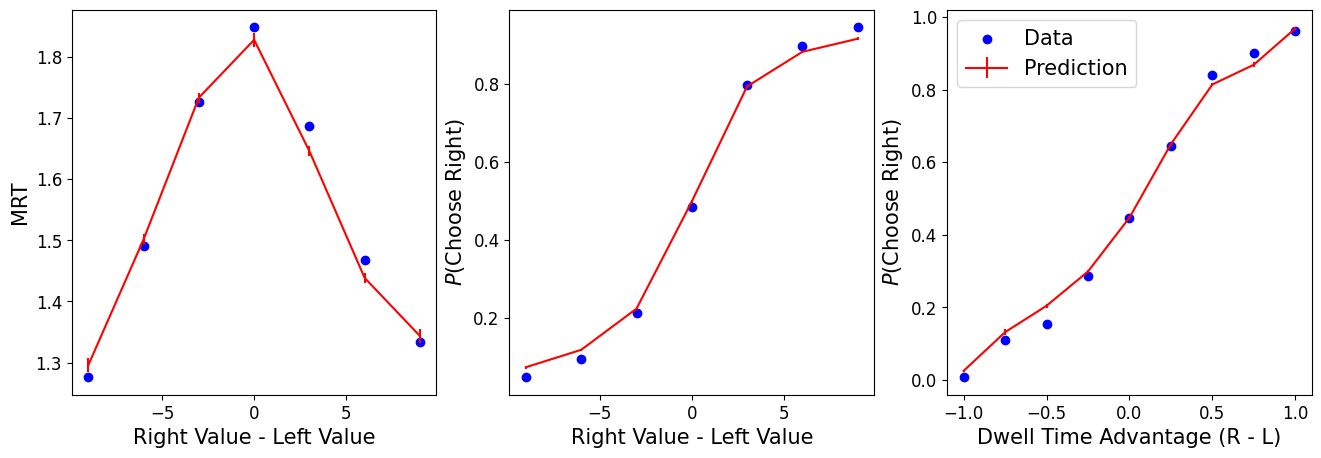

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/tv2017_complete_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

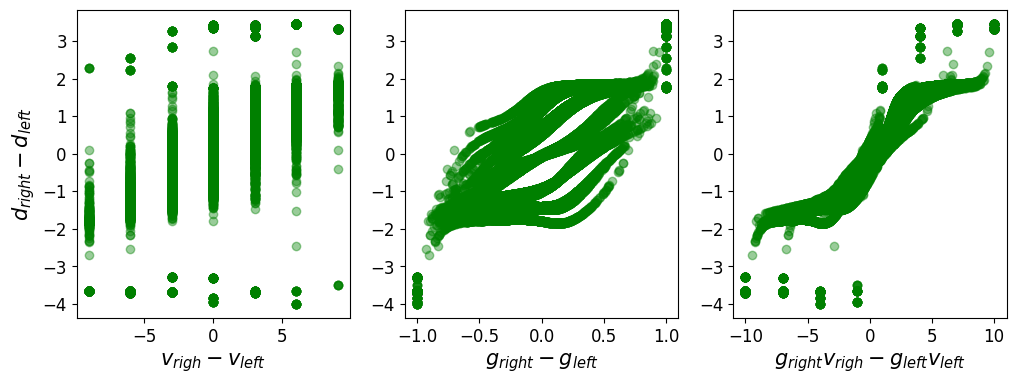

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 1] - X_test[:, 0], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 3] - X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 1]*X_test[:, 3] - X_test[:, 0]*X_test[:, 2], 
            pred_v[:, 1] - pred_v[:, 0], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/tv2017_complete_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');